In [ ]:
from endstate_correction.analysis import (
    plot_overlap_for_equilibrium_free_energy,
    plot_results_for_equilibrium_free_energy,
)
from endstate_correction.equ import calculate_u_kn
import pathlib
import endstate_correction
from endstate_correction.system import create_charmm_system
from openmm.app import CharmmParameterSet, CharmmPsfFile, CharmmCrdFile
import glob, pickle
import numpy as np
import os
from openmm import unit
import mdtraj as md
from endstate_correction.utils import convert_pickle_to_dcd_file
from endstate_correction.constant import kBT
from pymbar import mbar
from endstate_correction.protocol import Results, Protocol, perform_endstate_correction
from endstate_correction.analysis import plot_endstate_correction_results
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# bootstrap metric
def bootstrap_exp(fct, values):
    assert callable(fct) == True
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices = np.random.choice(range(0, len(values)), size=len(values), replace=True)
        selection = np.take(values, indices)
        r = fct(selection)['Delta_f']
        bootstrapped_metric.append(r)
    
    # define 90% CI
    alpha = 10.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if 
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    mean = fct(values)['Delta_f']

    return mean, lower, upper

def bootstrap_bar(fct, fw_f, rv_f):
    assert callable(fct) == True
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices_fw = np.random.choice(range(0, len(fw_f)), size=len(fw_f), replace=True)
        selection_fw = np.take(fw_f, indices_fw)
        indices_rv = np.random.choice(range(0, len(rv_f)), size=len(rv_f), replace=True)
        selection_rv = np.take(rv_f, indices_rv)
        r = fct(selection_fw, selection_rv)['Delta_f']
        bootstrapped_metric.append(r)
    
    # define 90% CI
    alpha = 10.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if 
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    mean = fct(fw_f, rv_f)['Delta_f']

    return mean, lower, upper

def plot_dist(r, system_name, axs):
        import seaborn as sns
        from pymbar import bar
        from pymbar.other_estimators import exp
        import matplotlib.pyplot as plt
        import numpy as np
        colors = sns.color_palette("flare", n_colors = 201) 

        tmp = np.append(r.dE_mm_to_qml, r.dE_qml_to_mm * -1)
        min_F = min(tmp)
        # draw histogramms and results for FEP and NEQ
        ##################################################
        # start with FEP
        w_F, w_R = r.dE_mm_to_qml, r.dE_qml_to_mm
        # print(w_F[:5])
        # print(w_R[:5])
        rexp_f, rexp_f_lower, rexp_f_upper = bootstrap_exp(exp, w_F)
        rexp_r, rexp_r_lower, rexp_r_upper = bootstrap_exp(exp, w_R)

        bar_bi, bar_bi_lower, bar_bi_upper = bootstrap_bar(bar, w_F, w_R)
        
        # equ dG
        equ_rs = [equ.compute_free_energy_differences()["Delta_f"][0][-1] for equ in r.equ_mbar]

        # offset everything and change sign
        rexp_f, rexp_f_lower, rexp_f_upper = rexp_f-min_F, rexp_f_lower-min_F, rexp_f_upper-min_F
        rexp_r, rexp_r_lower, rexp_r_upper = (rexp_r * -1)-min_F, (rexp_r_lower * -1)-min_F, (rexp_r_upper * -1)-min_F
        bar_bi, bar_bi_lower, bar_bi_upper = bar_bi-min_F, bar_bi_lower-min_F, bar_bi_upper-min_F
        equ_r = np.average(equ_rs)-min_F
        # 90% CI: https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module6-RandomError/PH717-Module6-RandomError11.html
        # CI = +- t-score(/sigma / sqrt(n))
        equ_dDG = 2.920 * (np.std(equ_rs) / np.sqrt(len(equ_rs))) 
        
        # print(f'{rexp_f=}')
        # print(f'{rexp_r=}')
        # print(f'{bar_bi=}')
        # print(f'{equ_r=}')

        axs[0].set_title(f'FEP - {system_name}', fontsize=15)
        ax1 = sns.kdeplot(w_F-min_F, label='f_forw', ax=axs[0], fill=True, alpha=.5,color=colors[0])
        y1, x = np.histogram(w_F-min_F, density=True)
        y2, x = np.histogram((w_R*-1)-min_F, density=True)

        y_max = max([y1.max(), y2.max()])
        #sns.rugplot(w_F-min_F, ax=ax1, lw=1, alpha=.1,color=colors[0])
        axs[0].scatter(w_F-min_F, np.random.uniform(low=(y_max/6) *  -1, high=0., size=len(w_F)), s=.4, c=colors[0], alpha=0.8)

        ax2 = sns.kdeplot((w_R*-1)-min_F, label='-f_rev', ax=axs[0], fill=True, alpha=.5,color=colors[-1])
        #sns.rugplot((w_R*-1)-min_F, ax=ax2, lw=1, alpha=.1,color=colors[-1])
        axs[0].scatter((w_R*-1)-min_F, np.random.uniform(low=(y_max/6) *  -1, high=0., size=len(w_R)), s=.4, c=colors[-1], alpha=0.8)

        # bidirectional estimate
        axs[0].axvline(x = bar_bi,
                color = 'red',lw=3 ,ls=':',
                label = r'$\Delta G_{bid}$')

        # EXP forward
        axs[0].axvline(x = rexp_f, 
                color = 'purple', lw=3,ls=':',
                label = r'$\Delta G_{forw}$', alpha=0.5)

        # EXP reverse
        axs[0].axvline(x = rexp_r, 
                color = 'green', lw=3,ls=':', alpha=0.5,
                label = r'$\Delta G_{rev}$')
        
        # equ dG
        axs[0].axvline(x=equ_r, 
                color = 'black',lw=3,ls='-', alpha=0.5,
                label = r'$\Delta G_{equ}$')


        textstr_fep = f'''$\Delta G_{{forw}}$ = {rexp_f:.2f} [{rexp_f_lower:.2f}; {rexp_f_upper:.2f}]
$\Delta G_{{rev}}$ = {rexp_r:.2f} [{rexp_r_upper:.2f}; {rexp_r_lower:.2f}]
$\Delta G_{{bid}}$ = {bar_bi:.2f} [{bar_bi_lower:.2f}; {bar_bi_upper:.2f}]
$\Delta G_{{equ}}$ = {equ_r:.2f} [{equ_r-equ_dDG:.2f}; {equ_r+equ_dDG:.2f}]'''



        ############################################################
        # now NEQ
        #tmp = np.append(r.W_mm_to_qml, r.W_qml_to_mm * -1)
        #min_F = abs(min(tmp))
        w_F, w_R = r.W_mm_to_qml, r.W_qml_to_mm
        rexp_f, rexp_f_lower, rexp_f_upper = bootstrap_exp(exp, w_F)
        rexp_r, rexp_r_lower, rexp_r_upper = bootstrap_exp(exp, w_R)

        bar_bi, bar_bi_lower, bar_bi_upper = bootstrap_bar(bar, w_F, w_R)
        
        
        # offset everything and change sign
        rexp_f, rexp_f_lower, rexp_f_upper = rexp_f-min_F, rexp_f_lower-min_F, rexp_f_upper-min_F
        rexp_r, rexp_r_lower, rexp_r_upper = (rexp_r * -1)-min_F, (rexp_r_lower * -1)-min_F, (rexp_r_upper * -1)-min_F
        bar_bi, bar_bi_lower, bar_bi_upper = bar_bi-min_F, bar_bi_lower-min_F, bar_bi_upper-min_F
        
        # print(f'{rexp_f=}')
        # print(f'{rexp_r=}')
        # print(f'{bar_bi=}')
        
        axs[1].set_title(f'NEQ - {system_name}', fontsize=15)

        ax1 = sns.kdeplot(w_F-min_F, ax=axs[1], fill=True, alpha=.5,color=colors[0])
        y1, x = np.histogram(w_F-min_F, density=True)
        y2, x = np.histogram((w_R*-1)-min_F, density=True)
        y_max = max([y1.max(), y2.max()])
        axs[1].scatter(w_F-min_F, np.random.uniform(low=(y_max/6) *  -1, high=0., size=len(w_F)), s=.4, c=colors[0], alpha=0.8)

        #sns.rugplot(w_F-min_F, ax=ax1, lw=2, alpha=.5,color=colors[0], height=.1,)
        ax2 = sns.kdeplot((w_R*-1)-min_F, ax=axs[1], fill=True, alpha=.5,color=colors[-1])
        #sns.rugplot((w_R*-1)-min_F, ax=ax2, lw=2, alpha=.6,color=colors[-1], height=.1,)
        axs[1].scatter((w_R*-1)-min_F, np.random.uniform(low=(y_max/6) *  -1, high=0., size=len(w_R)), s=.4, c=colors[-1], alpha=0.8)


        # bidirectional estimate
        axs[1].axvline(x = bar_bi,
                color = 'red',lw=3,ls=':', alpha=.5,
                label = r'$\Delta G_{bid}$')
        # EXP forward
        axs[1].axvline(x = rexp_f, 
                color = 'purple', lw=3,ls=':', alpha=.5,
                label = '$\Delta G_{forw}$')
        # EXP rev
        axs[1].axvline(x = rexp_r, 
                color = 'green',lw=3,ls=':', alpha=.5,
                label = '$\Delta G_{rev}$')
        # equ dG
        axs[1].axvline(x=equ_r, 
                color = 'black',lw=3,ls='-', alpha=.5,
                label = r'$\Delta G_{equ}$')


        textstr_neq = f'''$\Delta G_{{forw}}$ = {rexp_f:.2f} [{rexp_f_lower:.2f}; {rexp_f_upper:.2f}] 
$\Delta G_{{rev}}$ = {rexp_r:.2f} [{rexp_r_upper:.2f}; {rexp_r_lower:.2f}]
$\Delta G_{{bid}}$ = {bar_bi:.2f} [{bar_bi_lower:.2f}; {bar_bi_upper:.2f}]'''
#$\Delta G_{{equ}}$ = {equ_r:.2f} [{equ_r-equ_dDG:.2f}; {equ_r+equ_dDG:.2f}]'''


        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        axs[0].text(0.05, 0.95, textstr_fep, transform=axs[0].transAxes, fontsize=15,
                verticalalignment='top', bbox=props,horizontalalignment='left')
        axs[1].text(0.05, 0.95, textstr_neq, transform=axs[1].transAxes, fontsize=15,
                verticalalignment='top', bbox=props)
        
        # set axis labels and legend for both axis
        axs[0].get_yaxis().set_ticks([])
        axs[0].set_ylabel('Density')
        axs[1].get_yaxis().set_ticks([])
        axs[1].set_ylabel('Density')
        axs[0].legend(loc='upper right',fontsize=14, fancybox=True, framealpha=0.5)
        
        
def load_equ_samples(
    system_name: str, base:str, nr_of_samples: int = 5_000, nr_of_steps: int = 1_000, run_id:int = 1
)->list:
    """Helper function that loads trajectories from the test data"""

    trajs = []
    path = f"{base}/{system_name}/sampling_charmmff/run{run_id:02d}/"

    for lamb in np.linspace(0, 1, 11):
        file = glob.glob(
            f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.dcd"
        )
        if len(file) == 2:
            raise RuntimeError("Multiple traj files present. Abort.")
        if len(file) == 0:
            raise RuntimeError(
                "WARNING! Incomplete equ sampling. Proceed with cautions."
            )

        trajs.append(md.open(file[0]).read()[0] * unit.angstrom)
    return trajs

def convert_pickle_files(system_name: str, base:str, path_to_psf:str, path_to_crd:str, nr_of_samples: int = 5_000, nr_of_steps: int = 1_000, run_id:int=1):
    """Helper function that converts pickle to dcd files"""
    path = f"{base}/{system_name}/sampling_charmmff/run{run_id:02d}/"

    for lamb in np.linspace(0, 1, 11):
        file = glob.glob(
            f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.pickle"
        )
        if file[0]:
            dcd_output_path = f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.dcd"
            pdb_output_path = f"{path}/{system_name}.pdb"
            convert_pickle_to_dcd_file(file[0], path_to_psf, path_to_crd, dcd_output_path, pdb_output_path)


In [ ]:
path = pathlib.Path(endstate_correction.__file__).resolve().
hipen_testsystem = f"{path}/data/hipen_data"parent
from endstate_correction.constant import zinc_systems, blacklist

from itertools import zip_longest 

def grouper(n, iterable, padvalue=None):
    "grouper(3, 'abcdefg', 'x') --> ('a','b','c'), ('d','e','f'), ('g','x','x')"
    return zip_longest(*[iter(iterable)]*n, fillvalue=padvalue)

# systems that should not be plotted
all_used_systems = [x for x in zinc_systems if x[0] not in blacklist]

In [ ]:
########################################################
########################################################
# get all relevant files and calculate EXP and BAR for NEQ and FEP, and MBAR for EQU
nr_of_fep_switches = 2_000
for neq_switching_length in [5_001, 10_001, 20_001,50_001]:
    all_systems_results = {}
    # iterate over batches (system in batch are plotted togeter)
    for batch_idx, list_of_systems in enumerate(grouper(6, all_used_systems, ('','',''))):
        print(list_of_systems)
        fig, axs = plt.subplots(len(list_of_systems), 2, figsize=(13.0, 17.0), dpi=600)
        for idx, (system_name, smiles, hipen_id) in enumerate(list_of_systems):
            print(idx)
            # skip if no system name is provided
            if not system_name:
                continue
            # check if we can load pickle result file
            equ_mbar = []
            if os.path.isfile(f'{system_name}_results.pickle'):
                r = pickle.load(open(f'{system_name}_results.pickle', 'rb'))
            else:
                path_to_psf = f"{hipen_testsystem}/{system_name}/{system_name}.psf"
                path_to_crd = f"{hipen_testsystem}/{system_name}/{system_name}.crd"
                psf = CharmmPsfFile(path_to_psf)
                coord = CharmmCrdFile(path_to_crd)
                params = CharmmParameterSet(
                    f"{hipen_testsystem}/top_all36_cgenff.rtf",
                    f"{hipen_testsystem}/par_all36_cgenff.prm",
                    f"{hipen_testsystem}/{system_name}/{system_name}.str",
                )
                # define region that should be treated with the qml
                chains = list(psf.topology.chains())
                ml_atoms = [atom.index for atom in chains[0].atoms()]
                # create openmm simulation system
                sim = create_charmm_system(
                    psf=psf, parameters=params, env="vacuum", ml_atoms=ml_atoms
                )
                mbar_per_run = []
                # convert pickle files if necessary
                print('converting pickle file ...')
                for i in [1,2,3]:
                    try:
                        convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd, run_id = i)
                    except OSError:
                        print('Pickle files already converted ...')
                    # load all trajectories
                    trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew', run_id = i)
                    # calculate input for MBAR
                    N_k, u_kn = calculate_u_kn(
                        trajs=trajs,
                        every_nth_frame=5,
                        sim=sim,
                    )

                    # calculate equilibrium free energy difference
                    print('#-----------------------------------------#')
                    m = mbar.MBAR(u_kn, N_k)
                    print(f'Free energy difference: {m.compute_free_energy_differences()["Delta_f"][0][-1]}')
                    print(f'Free energy uncertainty: {m.compute_free_energy_differences()["dDelta_f"][0][-1]}')
                    print('#-----------------------------------------#')
                    equ_mbar.append(m)
                
                # perform FEP
                fep_file_name = f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_FEP_results_{nr_of_fep_switches}_switches.pickle'
                if os.path.isfile(fep_file_name):
                    r = pickle.load(open(fep_file_name, 'rb'))
                else:
                    # load all trajectories
                    mm_trajs = []
                    qml_trajs = []
                    for i in [1,2,3]:
                        # convert pickle files if necessary
                        try:
                            convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd, run_id = i)
                        except OSError:
                            print('Pickle files already converted ...')

                        trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew', run_id = i)
                        mm_trajs.extend(trajs[0])
                        qml_trajs.extend(trajs[-1])

                    fep_protocol = Protocol(
                        method="FEP",
                        direction="bidirectional",
                        sim=sim,
                        trajectories=[mm_trajs, qml_trajs],
                        nr_of_switches=nr_of_fep_switches,
                    )
                    r = perform_endstate_correction(fep_protocol)
                    pickle.dump(r, open(fep_file_name, 'wb'))
                # load NEQ results
                r.W_mm_to_qml = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_mm_to_qml_500_{neq_switching_length}.pickle', 'rb')) /kBT
                r.W_qml_to_mm = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_qml_to_mm_500_{neq_switching_length}.pickle', 'rb')) /kBT
                # put mbar in results object
                r.equ_mbar = equ_mbar 
                pickle.dump(r, open(f'{system_name}_results.pickle', 'wb'))

                #plot_endstate_correction_results(
                #    hipen_id, r, f"{hipen_id}_results.png"
                #)
                
            r.W_mm_to_qml = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_mm_to_qml_500_{neq_switching_length}.pickle', 'rb')) /kBT
            r.W_qml_to_mm = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_qml_to_mm_500_{neq_switching_length}.pickle', 'rb')) /kBT
            
            plot_dist(r, hipen_id, axs[idx])
            all_systems_results[hipen_id] = r
                
        plt.tight_layout()
        plt.savefig(f'{batch_idx}_batch_dist_{neq_switching_length=}.svg')
        plt.show()


In [ ]:
# if you have executed the cell above for the first time you need to save
# all_systems_results in a pickle file so that you can avoid rerunning it

#pickle.dump(all_systems_results, open('all_results.pickle', 'wb'))

In [ ]:
# if you have already saved the pickle file you can start here
import pickle

all_systems_results = pickle.load(open('all_results.pickle', 'rb'))

In [ ]:
########################################################
########################################################
# get all relevant files and calculate EXP and BAR for NEQ and FEP, and MBAR for EQU
nr_of_fep_switches = 2_000
neq_switching_length = 5_001
all_systems_results = {}
# iterate over batches (system in batch are plotted togeter)
for batch_idx, list_of_systems in enumerate(grouper(6, all_used_systems, ('','',''))):
    print(list_of_systems)
    fig, axs = plt.subplots(len(list_of_systems), 2, figsize=(13.0, 17.0), dpi=600)
    for idx, (system_name, smiles, hipen_id) in enumerate(list_of_systems):
        print(idx)
        # skip if no system name is provided
        if not system_name:
            continue
        # check if we can load pickle result file
        equ_mbar = []
        if os.path.isfile(f'{system_name}_results.pickle'):
            r = pickle.load(open(f'{system_name}_results.pickle', 'rb'))
        else:
            path_to_psf = f"{hipen_testsystem}/{system_name}/{system_name}.psf"
            path_to_crd = f"{hipen_testsystem}/{system_name}/{system_name}.crd"
            psf = CharmmPsfFile(path_to_psf)
            coord = CharmmCrdFile(path_to_crd)
            params = CharmmParameterSet(
                f"{hipen_testsystem}/top_all36_cgenff.rtf",
                f"{hipen_testsystem}/par_all36_cgenff.prm",
                f"{hipen_testsystem}/{system_name}/{system_name}.str",
            )
            # define region that should be treated with the qml
            chains = list(psf.topology.chains())
            ml_atoms = [atom.index for atom in chains[0].atoms()]
            # create openmm simulation system
            sim = create_charmm_system(
                psf=psf, parameters=params, env="vacuum", ml_atoms=ml_atoms
            )
            mbar_per_run = []
            # convert pickle files if necessary
            print('converting pickle file ...')
            for i in [1,2,3]:
                try:
                    convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd, run_id = i)
                except OSError:
                    print('Pickle files already converted ...')
                # load all trajectories
                trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew', run_id = i)
                # calculate input for MBAR
                N_k, u_kn = calculate_u_kn(
                    trajs=trajs,
                    every_nth_frame=5,
                    sim=sim,
                )

                # calculate equilibrium free energy difference
                print('#-----------------------------------------#')
                m = mbar.MBAR(u_kn, N_k)
                print(f'Free energy difference: {m.compute_free_energy_differences()["Delta_f"][0][-1]}')
                print(f'Free energy uncertainty: {m.compute_free_energy_differences()["dDelta_f"][0][-1]}')
                print('#-----------------------------------------#')
                equ_mbar.append(m)
            
            # perform FEP
            fep_file_name = f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_FEP_results_{nr_of_fep_switches}_switches.pickle'
            if os.path.isfile(fep_file_name):
                r = pickle.load(open(fep_file_name, 'rb'))
            else:
                # load all trajectories
                mm_trajs = []
                qml_trajs = []
                for i in [1,2,3]:
                    # convert pickle files if necessary
                    try:
                        convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd, run_id = i)
                    except OSError:
                        print('Pickle files already converted ...')

                    trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew', run_id = i)
                    mm_trajs.extend(trajs[0])
                    qml_trajs.extend(trajs[-1])

                fep_protocol = Protocol(
                    method="FEP",
                    direction="bidirectional",
                    sim=sim,
                    trajectories=[mm_trajs, qml_trajs],
                    nr_of_switches=nr_of_fep_switches,
                )
                r = perform_endstate_correction(fep_protocol)
                pickle.dump(r, open(fep_file_name, 'wb'))
            # load NEQ results
            r.W_mm_to_qml = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_mm_to_qml_500_{neq_switching_length}.pickle', 'rb')) /kBT
            r.W_qml_to_mm = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_qml_to_mm_500_{neq_switching_length}.pickle', 'rb')) /kBT
            # put mbar in results object
            r.equ_mbar = equ_mbar 
            pickle.dump(r, open(f'{system_name}_results.pickle', 'wb'))

            plot_endstate_correction_results(
                hipen_id, r, f"{hipen_id}_results.png"
            )
            
        
        plot_dist(r, hipen_id, axs[idx])
        all_systems_results[hipen_id] = r
            
    plt.tight_layout()
    plt.savefig(f'{batch_idx}_batch_dist_{neq_switching_length=}.png')
    plt.show()


In [ ]:
# generate data for plotting --- this 

from pymbar import bar
from pymbar.other_estimators import exp
from collections import defaultdict
from endstate_correction.constant import map_hp_to_zinc
ns = [k for k in all_systems_results.keys()]
neq_r_f, neq_r_r, neq_r_b = [],[],[]
fep_r_f, fep_r_r, fep_r_b = [],[],[]
res = defaultdict(dict)
for system_name in ns:
    print(system_name)
    r_f_tmp, r_r_tmp, r_b_tmp = [],[],[]
    tmp = np.array([])
    for switching_length in [5_001, 10_001, 20_001, 50_001]:
        res[system_name] = {'for': {switching_length : 0}, 'rev' : {switching_length : 0},'bid': {switching_length : 0}}
   
    for switching_length in [5_001, 10_001, 20_001, 50_001]:
        w_F = pickle.load(open(f'/data/shared/projects/endstate_rew/{map_hp_to_zinc[system_name]}/switching_charmmff/{map_hp_to_zinc[system_name]}_neq_ws_from_mm_to_qml_500_{switching_length}.pickle', 'rb')) /kBT
        w_R = pickle.load(open(f'/data/shared/projects/endstate_rew/{map_hp_to_zinc[system_name]}/switching_charmmff/{map_hp_to_zinc[system_name]}_neq_ws_from_qml_to_mm_500_{switching_length}.pickle', 'rb')) /kBT

        rexp_f, rexp_f_lower, rexp_f_upper = bootstrap_exp(exp, w_F)
        rexp_r, rexp_r_lower, rexp_r_upper = bootstrap_exp(exp, w_R)

        bar_bi, bar_bi_lower, bar_bi_upper = bootstrap_bar(bar, w_F, w_R)

        equ_rs = [equ.compute_free_energy_differences()["Delta_f"][0][-1] for equ in all_systems_results[system_name].equ_mbar]
        equ_r = np.average(equ_rs)
        res[system_name]['for'][switching_length]= rexp_f
        res[system_name]['rev'][switching_length]= rexp_r
        res[system_name]['bid'][switching_length]= bar_bi

        r_f_tmp.append(rexp_f-equ_r)
        r_r_tmp.append((rexp_r*-1)-equ_r)
        r_b_tmp.append((bar_bi)-equ_r)
    neq_r_f.append(r_f_tmp)
    neq_r_r.append(r_r_tmp)
    neq_r_b.append(r_b_tmp)


    w_F = all_systems_results[system_name].dE_mm_to_qml
    w_R = all_systems_results[system_name].dE_qml_to_mm
    # FEP
    rexp_f, rexp_f_lower, rexp_f_upper = bootstrap_exp(exp, w_F)
    rexp_r, rexp_r_lower, rexp_r_upper = bootstrap_exp(exp, w_R)

    bar_bi, bar_bi_lower, bar_bi_upper = bootstrap_bar(bar, w_F, w_R)
    fep_r_f.append(rexp_f-equ_r)
    fep_r_r.append((rexp_r*-1)-equ_r)
    fep_r_b.append((bar_bi)-equ_r)



In [ ]:
sns.set_style("ticks")
colors = sns.color_palette("YlOrBr", n_colors = 4) 

fig, axs = plt.subplots(1, 2, figsize=(8.0, 5.0), dpi=600)
for i in range(len(neq_r_f)):
    for j in range(len(neq_r_f[i])):
        axs[0].plot([neq_r_f[i][j]], ns[i],  '>', label='forw', c=colors[j], alpha=.8)
        axs[0].plot([neq_r_r[i][j]], ns[i],  '<', label='rev', c=colors[j], alpha=.8)
        axs[0].plot([neq_r_b[i][j]], ns[i],  'o', label='bid', c = colors[j], alpha=.8)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::64][:3], labels[::64][:3])
axs[0].axvline(1, linestyle='--' ,color='black')
axs[0].axvline(-1, linestyle='--' ,color='black')
axs[0].axvline(0, linestyle=':' ,color='red')

for i in range(len(fep_r_f)):
        axs[1].plot([fep_r_f[i]], ns[i], '>', label='forw', c=colors[j], alpha=.8)
        axs[1].plot([fep_r_r[i]], ns[i],  '<', label='rev', c=colors[j], alpha=.8)
        axs[1].plot([fep_r_b[i]], ns[i],  'o', label='bid', c = colors[j], alpha=.8)

axs[1].axvline(1, linestyle='--' ,color='black')
axs[1].axvline(-1, linestyle='--' ,color='black')
axs[1].axvline(0, linestyle=':' ,color='red')


#axs[0].set_xlim((-2,2))
#axs[1].set_xlim((-5,5))

axs[0].set_title('NEQ')
axs[1].set_title('FEP')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel(r'$\Delta$G(EQU, NEQ) [kT]')
axs[1].set_xlabel(r'$\Delta$G(EQU, FEP) [kT]')

#axs[1].set_yticklabels(labels=[])
sns.despine()
plt.savefig(f'neq_fep_overview.svg')
plt.show()


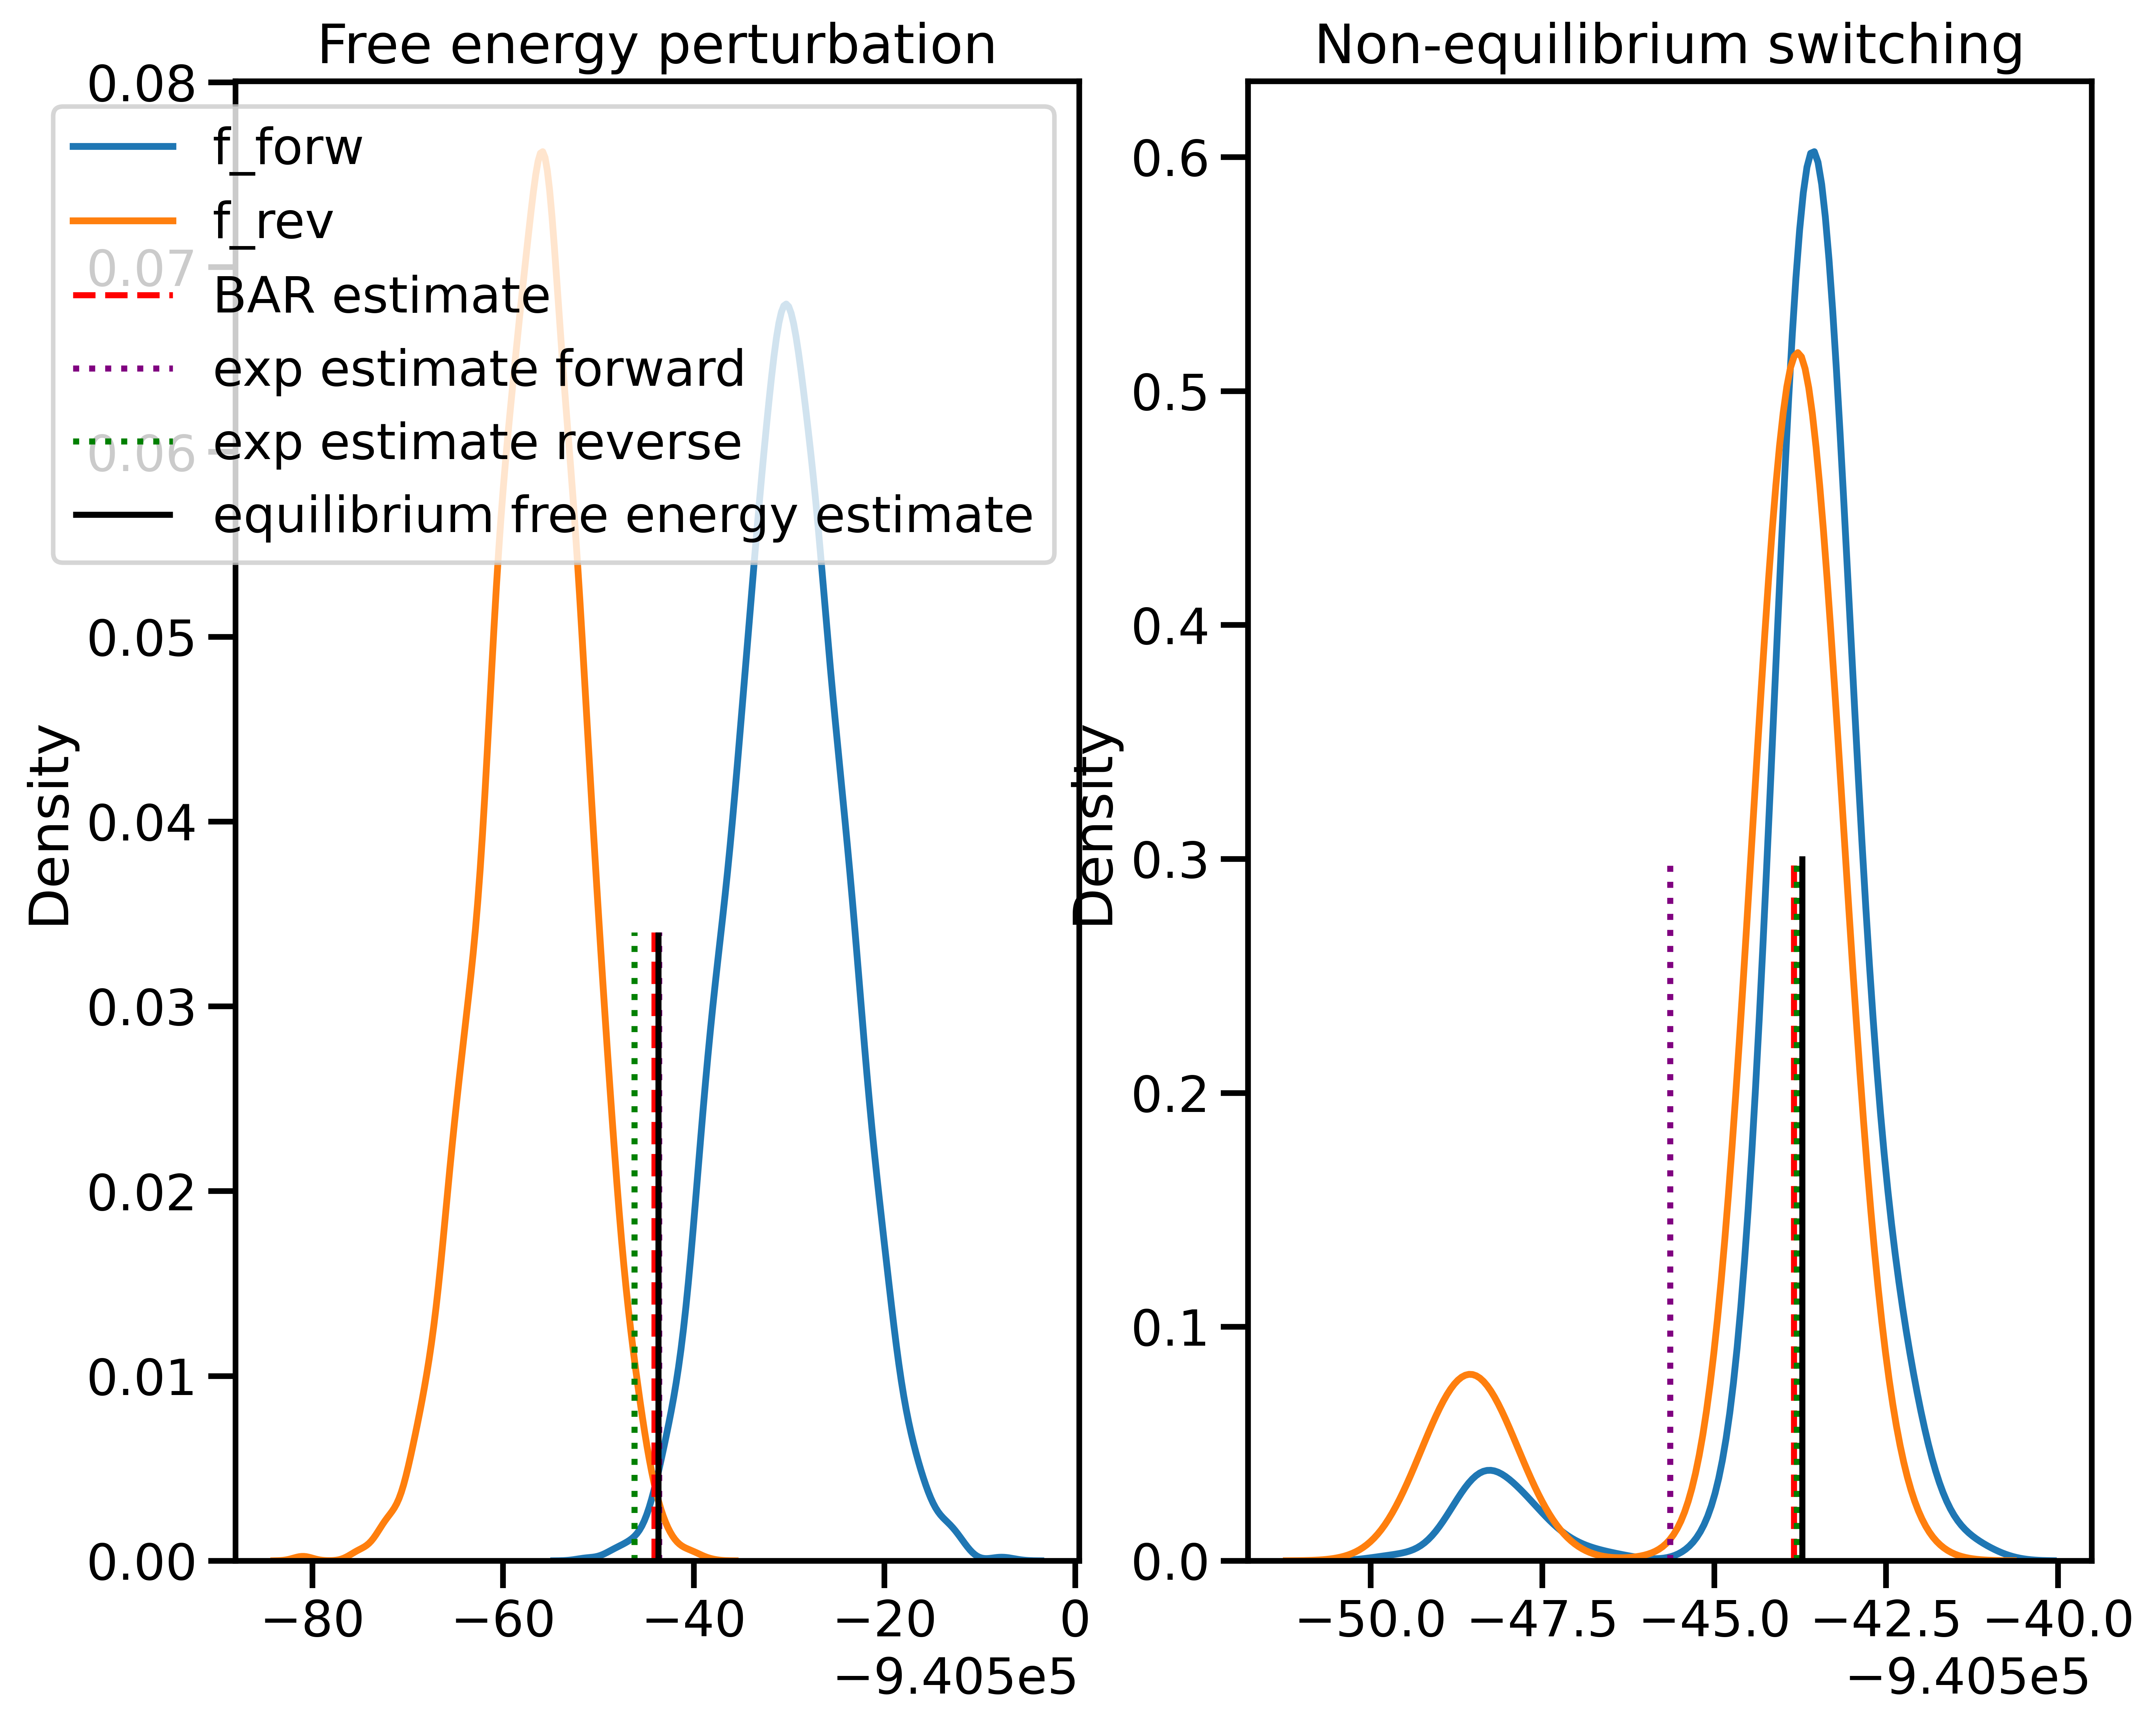

In [2]:
import seaborn as sns
from pymbar import bar
from pymbar.other_estimators import exp
import matplotlib.pyplot as plt

# draw histogramms and results for FEP and NEQ
# start with FEP
w_F, w_R = r.dE_mm_to_qml, r.dE_qml_to_mm
results = bar(w_F, w_R)
rexp_f = exp(w_F)
rexp_r = exp(w_R)
fig, axs = plt.subplots(1, 2, figsize=(11.0, 9), dpi=600)

axs[0].set_title('Free energy perturbation')
ax = sns.kdeplot(w_F, label='f_forw', ax=axs[0])
kde_curve = ax.lines[0]
y1 = kde_curve.get_ydata().max()
ax = sns.kdeplot(w_R*-1, label='f_rev', ax=axs[0])
kde_curve = ax.lines[0]
y2 = kde_curve.get_ydata().max()

axs[0].vlines(x = results["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'red',lw=2,ls='--',
           label = 'BAR estimate')
axs[0].vlines(x = rexp_f["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'purple', lw=2,ls=':',
           label = 'exp estimate forward')
axs[0].vlines(x = rexp_r["Delta_f"]*-1, ymin = 0, ymax = max(y1, y2)/2,
           colors = 'green',lw=2,ls=':',
           label = 'exp estimate reverse')
axs[0].vlines(r.equ_mbar.compute_free_energy_differences()["Delta_f"][0][-1], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'black',lw=2,ls='-',
           label = 'equilibrium free energy estimate')


# now NEQ
w_F, w_R = r.W_mm_to_qml, r.W_qml_to_mm
results = bar(w_F, w_R)
rexp_f = exp(w_F)
rexp_r = exp(w_R)
axs[1].set_title('Non-equilibrium switching')

ax = sns.kdeplot(w_F, label='f_forw', ax=axs[1])
kde_curve = ax.lines[0]
y1 = kde_curve.get_ydata().max()
ax = sns.kdeplot(w_R*-1, label='f_rev', ax=axs[1])
kde_curve = ax.lines[0]
y2 = kde_curve.get_ydata().max()

axs[1].vlines(x = results["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'red',lw=2,ls='--',
           label = 'BAR estimate')
axs[1].vlines(x = rexp_f["Delta_f"], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'purple', lw=2,ls=':',
           label = 'exp estimate forward')
axs[1].vlines(x = rexp_r["Delta_f"]*-1, ymin = 0, ymax = max(y1, y2)/2,
           colors = 'green',lw=2,ls=':',
           label = 'exp estimate reverse')
axs[1].vlines(r.equ_mbar.compute_free_energy_differences()["Delta_f"][0][-1], ymin = 0, ymax = max(y1, y2)/2,
           colors = 'black',lw=2,ls='-',
           label = 'equilibrium free energy estimate')

axs[0].legend(loc='upper right',)
plt.show()